# Join data for Shots

* Group json files by repetitions
* Extract error and runs data
* Average this data
* Save in a new json file

In [22]:
from os import walk
import json
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator

from sklearn.metrics import mean_squared_error


optimizers = ["gradient_descent", "spsa", "adam", "demon_adam"]
train_types= ['vqe','meta', 'opt_meta']

with open('./h2_fci.json', 'r') as reader:
    # Read & print the entire file
    data = reader.read()
    fci_h2 = json.loads(data)  

fci_energies = fci_h2["energies"]


f = []
for (dirpath, dirnames, filenames) in walk('./exp_runs'):
    f.extend(filenames)
    break

print(len(f))

50


In [23]:
# Ordered by pairs - fd,ps
main_groups = [ "simplified2design_3layers_fd", "simplified2design_3layers_ps", "simplified2design_4layers_fd", "simplified2design_4layers_ps", "meta_single_doubles_fd", "meta_single_doubles_ps", "meta_doubles_fd", "meta_doubles_ps", "kupccgsd_1layers_fd", "kupccgsd_1layers_ps", ]

In [24]:
condensed_data = []

for group_count,file_name_base in enumerate(main_groups):
    this_group = []
    files_in_group = [f_name for f_name in f if file_name_base in f_name]
    for file_name in files_in_group:
        with open(f'exp_runs/{file_name}', 'r') as reader:
            # Read & print the entire file
            data = reader.read()
            this_group.append(json.loads(data))    
    
    group_dict = {i:{"errors":[0.0 for _ in train_types], "runs":[ 0 for _ in train_types]} for i in optimizers}
    for opt in optimizers:
        for data_entry in this_group:
            for count, result_type in enumerate(train_types):
                if result_type == 'meta':
                    group_dict[opt]["runs"][count] += data_entry['results'][opt][result_type]['runs']/len(this_group)
                    group_dict[opt]["errors"][count] += mean_squared_error(fci_energies, data_entry['results'][opt][result_type]["energies_after_meta"], squared=False)/len(this_group)

                else:
                    group_dict[opt]["runs"][count] += np.sum(data_entry['results'][opt][result_type]['runs_per_step'])/len(this_group)
                    group_dict[opt]["errors"][count] += mean_squared_error(fci_energies, [energy[-1] for energy in data_entry['results'][opt][result_type]["energies"]], squared=False)/len(this_group)                    

    condensed_data.append(group_dict)


In [25]:
plot_data = []
for i in range(int(len(main_groups)/2)):
    for count,result_type in enumerate(train_types):
        row=[]
        for opt in optimizers:
            row.append(condensed_data[2*i][opt]["errors"][count])
            row.append(condensed_data[2*i+1][opt]["errors"][count])
        plot_data.append(row)


In [26]:
import pandas as pd

result_types = ['vqe', 'meta', 'opt-meta']
arrays = []
for i in range(int(len(main_groups)/2)):
    for result_type in train_types:
        arrays.append((main_groups[2*i][0:-3].replace('_', '-'), result_type))

In [27]:
columns = [('Gradient','fd'),('Gradient','ps'),('SPSA','fd'),('SPSA','ps'),('ADAM','fd'),('ADAM','ps'),('DEMON ADAM','fd'),('DEMON ADAM','ps')]

In [28]:
df = pd.DataFrame(plot_data, index=arrays, columns = columns)
df.columns = pd.MultiIndex.from_tuples(df.columns)
df.index = pd.MultiIndex.from_tuples(df.index)
pd.options.display.float_format = '{:12.2e}'.format
df

Gradient                      SPSA   
                                             fd           ps           fd   
simplified2design-3layers vqe          8.68e-01     7.36e-02     2.25e-01  \
                          meta         8.66e-01     7.85e-01     5.67e-01   
                          opt_meta     8.50e-01     2.26e-01     4.98e-01   
simplified2design-4layers vqe          8.54e-01     5.47e-02     1.82e-01   
                          meta         8.64e-01     8.47e-01     6.32e-01   
                          opt_meta     8.12e-01     1.68e-01     3.72e-01   
meta-single-doubles       vqe          5.96e-01     4.87e-03     1.22e-02   
                          meta         6.11e-01     2.83e-01     1.81e-01   
                          opt_meta     6.55e-01     5.72e-02     9.64e-02   
meta-doubles              vqe          6.02e-01     3.44e-03     8.30e-03   
                          meta         1.72e-01     7.38e-02     1.60e-01   
                          opt_meta     5.54e-01     1.86e-02     3.38e-02   
kupccgsd-1layers          vqe          6.34e-01     1.36e-03     4.22e-03   
                          meta         5.96e-01     3.55e-01     1.47e-01   
                          opt_meta     6.36e-01     1.10e-02     1.04e-01   

                                                        ADAM                
                                             ps           fd           ps   
simplified2design-3layers vqe          1.35e-01     6.61e-01     9.60e-02  \
                          meta         5.95e-01     9.11e-01     9.13e-01   
                          opt_meta     5.03e-01     8.14e-01     1.58e-01   
simplified2design-4layers vqe          1.48e-01     6.73e-01     5.70e-03   
                          meta         5.87e-01     8.17e-01     8.33e-01   
                          opt_meta     4.11e-01     7.93e-01     9.89e-02   
meta-single-doubles       vqe          1.96e-02     1.09e-01     2.66e-02   
                          meta         2.14e-01     2.01e-01     2.69e-01   
                          opt_meta     1.16e-01     1.86e-01     9.45e-02   
meta-doubles              vqe          1.15e-02     8.74e-02     1.36e-03   
                          meta         1.02e-01     1.97e-01     6.93e-02   
                          opt_meta     5.31e-02     1.40e-01     3.84e-02   
kupccgsd-1layers          vqe          5.45e-03     8.25e-02     9.90e-04   
                          meta         1.07e-01     3.24e-01     4.38e-01   
                          opt_meta     1.13e-01     2.82e-01     2.43e-02   

                                     DEMON ADAM               
                                             fd           ps  
simplified2design-3layers vqe          6.39e-01     6.37e-02  
                          meta         8.56e-01     8.58e-01  
                          opt_meta     8.15e-01     1.63e-01  
simplified2design-4layers vqe          6.88e-01     7.20e-03  
                          meta         8.43e-01     7.85e-01  
                          opt_meta     7.91e-01     1.24e-01  
meta-single-doubles       vqe          9.91e-02     2.71e-02  
                          meta         2.05e-01     2.05e-01  
                          opt_meta     1.95e-01     1.06e-01  
meta-doubles              vqe          5.97e-02     2.72e-02  
                          meta         1.55e-01     8.59e-02  
                          opt_meta     1.25e-01     5.28e-02  
kupccgsd-1layers          vqe          1.07e-01     8.67e-04  
                          meta         3.16e-01     4.09e-01  
                          opt_meta     2.91e-01     1.02e-01

In [32]:
## Simplified: (WIRES + LAYERS*(WIRES-1)*2)
## Single Double Excitations: 1 per excitation
## kupccgsd: 6*LAYERS

## For fd: (Nvars*4)+1
overheads_fd = [89,113,13,5,25]

## For ps - simplified: (Nvars*2)*4
## For ps - excitations, kupccgsd: (Nvars*4)*4
overheads_ps = [176,224,48,16,96]

index_per_runs_plot_fd = [0,2,4,6,8]
index_per_runs_plot_ps = [1,3,5,7,9]

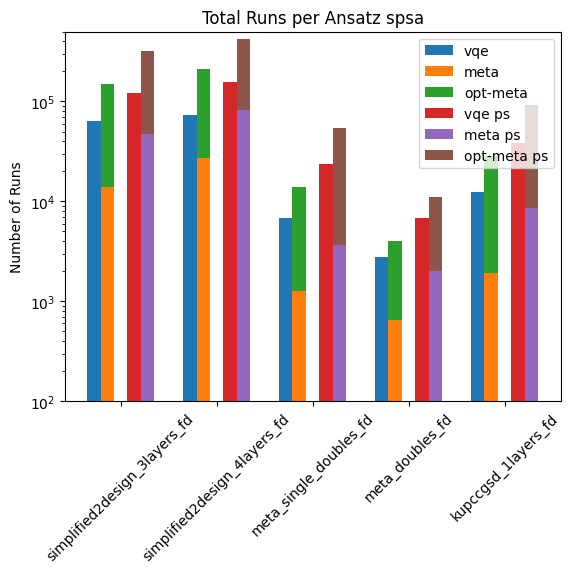

In [39]:
opt_runs = optimizers[1]

fig, ax = plt.subplots()

vqe_data = [condensed_data[idx][opt_runs]["runs"][0]*overheads_fd[count] for count,idx in enumerate(index_per_runs_plot_fd)]
meta_runs = [condensed_data[idx][opt_runs]["runs"][1]*overheads_fd[count]*5 for count,idx in enumerate(index_per_runs_plot_fd)]
opt_meta_data = [condensed_data[idx][opt_runs]["runs"][2]*overheads_fd[count] for count,idx in enumerate(index_per_runs_plot_fd)]

vqe_data_ps = [condensed_data[idx][opt_runs]["runs"][0]*overheads_ps[count] for count,idx in enumerate(index_per_runs_plot_ps)]
meta_runs_ps = [condensed_data[idx][opt_runs]["runs"][1]*overheads_ps[count]*5 for count,idx in enumerate(index_per_runs_plot_ps)]
opt_meta_data_ps = [condensed_data[idx][opt_runs]["runs"][2]*overheads_ps[count] for count,idx in enumerate(index_per_runs_plot_ps)]



ind = np.arange(len(vqe_data)) 

width = 0.14                    # the width of the bars

ax.set_ylabel('Number of Runs')
ax.set_title(f'Total Runs per Ansatz {opt_runs}')
xTickMarks = [main_groups[idx] for idx in index_per_runs_plot_fd]
ax.set_xticks(ind+(2*width))
xtickNames = ax.set_xticklabels(xTickMarks)
plt.setp(xtickNames, rotation=45, fontsize=10)


plt.bar(np.arange(len(vqe_data)), vqe_data, width=width, label = "vqe")
plt.bar(np.arange(len(meta_runs))+ width, meta_runs, width=width, label="meta")
plt.bar(np.arange(len(opt_meta_data))+ width, opt_meta_data, width=width, bottom= meta_runs, label="opt-meta")

plt.bar(np.arange(len(vqe_data_ps))+ width*3, vqe_data_ps, width=width, label="vqe ps")
plt.bar(np.arange(len(meta_runs_ps))+ width*4, meta_runs_ps, width=width, label="meta ps")
plt.bar(np.arange(len(opt_meta_data_ps))+ width*4, opt_meta_data_ps, width=width, bottom= meta_runs_ps, label="opt-meta ps")
ax.legend()
plt.yscale('log')
plt.ylim(100, 500000)
plt.show()

[3450.0, 990.0, 3484.0000000000005, 2639.0000000000005, 9628.0]


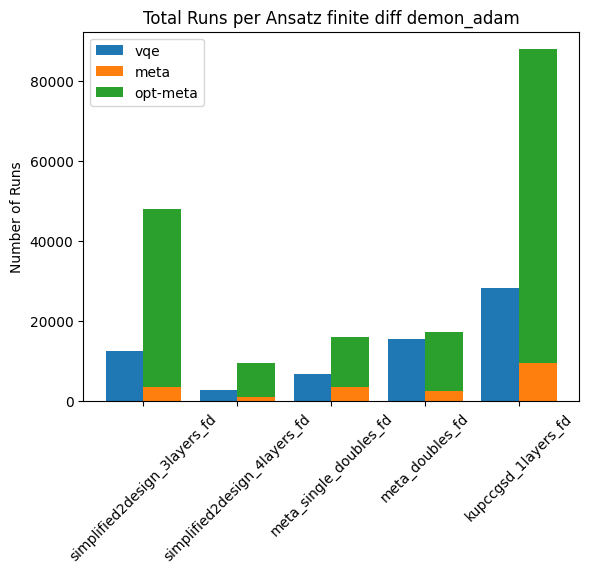

In [31]:
opt_runs = optimizers[3]

fig, ax = plt.subplots()

vqe_data = [condensed_data[idx][opt_runs]["runs"][0]*overheads_fd[count] for count,idx in enumerate(index_per_runs_plot_ps)]
meta_runs = [condensed_data[idx][opt_runs]["runs"][1]*overheads_fd[count]*5 for count,idx in enumerate(index_per_runs_plot_ps)]
opt_meta_data = [condensed_data[idx][opt_runs]["runs"][2]*overheads_fd[count] for count,idx in enumerate(index_per_runs_plot_ps)]


print(meta_runs)


ind = np.arange(len(vqe_data)) 

width = 0.4                      # the width of the bars

ax.set_ylabel('Number of Runs')
ax.set_title(f'Total Runs per Ansatz finite diff {opt_runs}')
xTickMarks = [main_groups[idx] for idx in index_per_runs_plot_fd]
ax.set_xticks(ind+(width/2))
xtickNames = ax.set_xticklabels(xTickMarks)
plt.setp(xtickNames, rotation=45, fontsize=10)


plt.bar(np.arange(len(vqe_data)), vqe_data, width=width, label = "vqe")
plt.bar(np.arange(len(meta_runs))+ width, meta_runs, width=width, label="meta")
plt.bar(np.arange(len(opt_meta_data))+ width, opt_meta_data, width=width, bottom= meta_runs, label="opt-meta")
ax.legend()
plt.show()